In [167]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [168]:
from sklearn.preprocessing import StandardScaler # data normalization
from sklearn.model_selection import train_test_split # data split
from sklearn.tree import DecisionTreeClassifier # Decision tree algorithm
from sklearn.neighbors import KNeighborsClassifier # KNN algorithm
from sklearn.ensemble import RandomForestClassifier # Random forest tree algorithm
from sklearn.linear_model import LogisticRegression # Logistic regression algorithm
from sklearn.svm import SVC # SVM algorithm

from sklearn.metrics import confusion_matrix # evaluation metric
from sklearn.metrics import accuracy_score # evaluation metric
from sklearn.metrics import f1_score # evaluation metric

In [169]:
df=pd.read_csv("data.csv")

In [170]:
df1=df.copy()

Let's peek at the top several rows of the DataFrame

Here's what the data mean
- user A string indicating the username of the person authenticating.
- application A string value with the name of the application being accessed.
- device_type A string value with a description of the type of device used for a second factor. 
- time An integer value giving the time of day that the auth was made (seconds after midnight) 
- fraud 0/1 indicator of whether the authentication was fraudulent.

In [171]:
df.head()

,user,application,device_type,time,fraud
0,user_1,application_1,android,1904.0,0
1,user_1,application_2,android,12075.0,0
2,user_1,application_2,android,12540.0,0
3,user_1,application_2,android,14744.0,0
4,user_1,application_1,android,16339.0,0


Cool we have some data! But how many rows and columns are there? Call .shape to get the number of rows and columns of the DataFrame.

In [172]:
df.shape

(1014, 5)

In [173]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1014 entries, 0 to 1013
Data columns (total 5 columns):
user           1014 non-null object
application    1014 non-null object
device_type    917 non-null object
time           868 non-null float64
fraud          1014 non-null int64
dtypes: float64(1), int64(1), object(3)
memory usage: 39.7+ KB


# Table of Contents (with hyperlinks)

- [Question 1: Cleaning and Exploratory data analysis](#A) 
- [Question 2: Predictive Modeling](#B) 
- [Question 3: Devices and applications](#C)

# Cleaning <a id="A"></a>


###	Null values:
-	Find out the null values in the dataframe
-	Created a new column ‘device_type_new’ where null values are marked as ‘undefined’
-   Replaced the null values in time field with 0.

In [174]:
df.describe()

,time,fraud
count,8.680000e+02,1014.000000
mean,4.243908e+04,0.101578
std,3.581930e+04,0.302242
min,1.904000e+03,0.000000
25%,3.021375e+04,0.000000
50%,3.845000e+04,0.000000
75%,4.996625e+04,0.000000
max,1.000003e+06,1.000000


In [175]:
#Let's check for null values
df.isnull().sum()

user             0
application      0
device_type     97
time           146
fraud            0
dtype: int64

device_type and time as a lot of null values

In [176]:
#Created a new column ‘device_type_new’ where null values are marked as ‘undefined’
df['device_type_new']=df['device_type'].fillna('undefined')
df['device_type_new'].isnull().sum()

0

In [177]:
#Since the data is less, I dont want to remove the rows with null values so replaced the null values in time field with 0.
df['time']= df['time'].fillna(0)
df['time'].isnull().sum()

0

# Exploratory data analysis

In [178]:
#Let's check for class imbalance by checking number of fraudulent transactions.
df['fraud'].value_counts()

0    911
1    103
Name: fraud, dtype: int64

In [179]:
valid_count = len(df[df.fraud == 0])
fraud_count = len(df[df.fraud == 1])
fraud_percentage = round(fraud_count/valid_count*100, 2)
fraud_percentage

11.31

There are 103 Fraudulent transactions and 911 valid transactions. Its looks like a class imbalance since the ratio of fradulent to valid transactions is 11.31%.

Let’s first apply our models without balancing it and if we don’t get a good accuracy, precision, recall then we can find a way to balance this dataset. But first, let’s implement the model without it and will balance the data only if needed.

#### Authentication time
##### Divide the time data into - morning, day, night, evening
- Night- 12am - 5am (0 - 18000)
- Morning - 5am - 9am (18001 - 32400)
- Day - 9am - 5pm (32401 - 61200)
- Evening - 5pm - 12am (61201 - 86400)

In [212]:
df['time_of_day'] = df['time']
df.head()

,user,application,device_type,time,fraud,device_type_new,time_of_day
0,user_1,application_1,android,1904.0,0,android,1904.0
1,user_1,application_2,android,12075.0,0,android,12075.0
2,user_1,application_2,android,12540.0,0,android,12540.0
3,user_1,application_2,android,14744.0,0,android,14744.0
4,user_1,application_1,android,16339.0,0,android,16339.0


In [215]:
def time_to_time_of_day(time):
    
    if 0 <= time < 18000: 
        return 'Night'
    elif 18000<= time <32400:
        return 'Morning'
    elif 32400 <= time <61200:
        return 'Day'
    elif 61200 <= time <86400:
        return 'Evening'
    else:
        return 'Invalid'

In [216]:
df['time_of_day']= df['time'].apply(time_to_time_of_day)

In [217]:
df.head()

,user,application,device_type,time,fraud,device_type_new,time_of_day
0,user_1,application_1,android,1904.0,0,android,Night
1,user_1,application_2,android,12075.0,0,android,Night
2,user_1,application_2,android,12540.0,0,android,Night
3,user_1,application_2,android,14744.0,0,android,Night
4,user_1,application_1,android,16339.0,0,android,Night


In [222]:
df['time_of_day'].value_counts()

Day        490
Morning    243
Night      165
Evening    115
Name: time_of_day, dtype: int64

In [221]:
df.drop(df.loc[df['time_of_day']=='Invalid'].index, inplace=True)
#df.drop(df['time_of_day']=='Invalid')

## Q2: Predictive Modeling <a id="B"></a>
### The attached dataset includes a boolean column called fraud. Please create a baseline predictive model that uses the other available variables to predict whether an authentication is fraudulent. Provide some measure of how well you would expect this model to perform on future authentication records from this population of users. Assume that each authentication is independent from other authentications and that there aren’t long-term temporal patterns 

## Encoding
Next step is to convert categorical data: user, application and device_type into numeric values to be able to use in our model. We will be using one hot encoding to achieve the same.

In [223]:
def get_dummies(df, col_name):
    dummies=pd.get_dummies(df[col_name], prefix=col_name)
    df=pd.concat([dummies, df], axis=1)
    return df

In [228]:
df2 = df

In [229]:
df2 = get_dummies(df2, 'user')
df2 = get_dummies(df2,'application')
df2 = get_dummies(df2, 'device_type_new')
df2 = get_dummies(df2, 'time_of_day')
df2.head()

,time_of_day_Day,time_of_day_Evening,time_of_day_Morning,time_of_day_Night,device_type_new_android,device_type_new_iphone,device_type_new_undefined,device_type_new_yubikey,application_application_1,application_application_2,...,user_user_2,user_user_3,user_user_4,user,application,device_type,time,fraud,device_type_new,time_of_day
0,0,0,0,1,1,0,0,0,1,0,...,0,0,0,user_1,application_1,android,1904.0,0,android,Night
1,0,0,0,1,1,0,0,0,0,1,...,0,0,0,user_1,application_2,android,12075.0,0,android,Night
2,0,0,0,1,1,0,0,0,0,1,...,0,0,0,user_1,application_2,android,12540.0,0,android,Night
3,0,0,0,1,1,0,0,0,0,1,...,0,0,0,user_1,application_2,android,14744.0,0,android,Night
4,0,0,0,1,1,0,0,0,1,0,...,0,0,0,user_1,application_1,android,16339.0,0,android,Night


In [230]:
df2 = df2.drop(['user', 'application', 'device_type', 'device_type_new', 'time_of_day', 'time'], axis=1)
df2.head()

,time_of_day_Day,time_of_day_Evening,time_of_day_Morning,time_of_day_Night,device_type_new_android,device_type_new_iphone,device_type_new_undefined,device_type_new_yubikey,application_application_1,application_application_2,user_user_1,user_user_2,user_user_3,user_user_4,fraud
0,0,0,0,1,1,0,0,0,1,0,1,0,0,0,0
1,0,0,0,1,1,0,0,0,0,1,1,0,0,0,0
2,0,0,0,1,1,0,0,0,0,1,1,0,0,0,0
3,0,0,0,1,1,0,0,0,0,1,1,0,0,0,0
4,0,0,0,1,1,0,0,0,1,0,1,0,0,0,0


## Scaling

In [184]:
#using standard scaler to scale the time column
scaler = StandardScaler()
time = df2['time'].values

df2['time'] = scaler.fit_transform(time.reshape(-1, 1))

df2.head()

,device_type_new_android,device_type_new_iphone,device_type_new_undefined,device_type_new_yubikey,application_application_1,application_application_2,user_user_1,user_user_2,user_user_3,user_user_4,time,fraud
0,1,0,0,0,1,0,1,0,0,0,-0.947859,0
1,1,0,0,0,0,1,1,0,0,0,-0.667807,0
2,1,0,0,0,0,1,1,0,0,0,-0.655003,0
3,1,0,0,0,0,1,1,0,0,0,-0.594317,0
4,1,0,0,0,1,0,1,0,0,0,-0.550400,0


## Feature Selection & Data Split
In this process, we are going to define the independent (X) and the dependent variables (Y). Using the defined variables, we will split the data into a training set and testing set which is further used for modeling and evaluating. We can split the data easily using the ‘train_test_split’ algorithm in python.

In [231]:
# DATA SPLIT

X = df2.drop('fraud', axis = 1).values
y = df2['fraud'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [232]:
# MODELING
#Decision Tree

tree_model = DecisionTreeClassifier(max_depth = 4, criterion = 'entropy')
tree_model.fit(X_train, y_train)
tree_yhat = tree_model.predict(X_test)

I am using the decision tree model with the‘DecisionTreeClassifier’ to build the model. I have mentioned the ‘max_depth’ to be ‘4’ which means allowing the tree to split four times and the ‘criterion’ to be ‘entropy’ which determines when to stop splitting the tree. Finally, we have fitted and stored the predicted values into the ‘tree_yhat’ variable. Further we calculating the accuracy and f1 score for the same.

In [233]:
accuracy_score(y_test, tree_yhat)

0.9359605911330049

In [234]:
f1_score(y_test, tree_yhat)

0.4347826086956522

Since this is a class imbalance problem, f1 score provides a better evaluation score than accuracy because it gives more weightage to FP's and FN's. We can see from the above score that accuracy is 91.1% and f1_score is 18.2% approx. We might have to see the correlation of variables with our target variables and modify our algorithm or take care of class imbalance problem.

In [235]:
df2.corr()

,time_of_day_Day,time_of_day_Evening,time_of_day_Morning,time_of_day_Night,device_type_new_android,device_type_new_iphone,device_type_new_undefined,device_type_new_yubikey,application_application_1,application_application_2,user_user_1,user_user_2,user_user_3,user_user_4,fraud
time_of_day_Day,1.000000,-0.346384,-0.543757,-0.426964,0.383179,-0.223679,-0.160579,-0.179464,0.220734,-0.220734,0.461664,-0.245320,-0.147694,-0.240819,-0.018447
time_of_day_Evening,-0.346384,1.000000,-0.201034,-0.157854,-0.192474,0.212942,-0.095302,0.138782,-0.125188,0.125188,-0.251854,0.207890,-0.101274,0.203023,-0.017432
time_of_day_Morning,-0.543757,-0.201034,1.000000,-0.247800,0.093073,0.058973,-0.127813,-0.095785,-0.074382,0.074382,-0.040344,-0.144764,-0.130358,0.280873,0.032832
time_of_day_Night,-0.426964,-0.157854,-0.247800,1.000000,-0.460849,0.051579,0.446997,0.234414,-0.105165,0.105165,-0.361767,0.320809,0.437632,-0.173309,0.001973
device_type_new_android,0.383179,-0.192474,0.093073,-0.460849,1.000000,-0.589001,-0.434520,-0.446799,0.289915,-0.289915,0.715514,-0.509315,-0.406821,-0.120575,-0.047580
device_type_new_iphone,-0.223679,0.212942,0.058973,0.051579,-0.589001,1.000000,-0.143543,-0.147600,-0.174807,0.174807,-0.436887,0.261711,-0.132460,0.408798,0.046202
device_type_new_undefined,-0.160579,-0.095302,-0.127813,0.446997,-0.434520,-0.143543,1.000000,-0.108888,-0.339601,0.339601,-0.313569,-0.120824,0.857888,-0.154010,0.001523
device_type_new_yubikey,-0.179464,0.138782,-0.095785,0.234414,-0.446799,-0.147600,-0.108888,1.000000,0.084329,-0.084329,-0.298130,0.609085,-0.027687,-0.158786,0.017680
application_application_1,0.220734,-0.125188,-0.074382,-0.105165,0.289915,-0.174807,-0.339601,0.084329,1.000000,-1.000000,0.462259,0.123634,-0.277538,-0.476681,-0.037327
application_application_2,-0.220734,0.125188,0.074382,0.105165,-0.289915,0.174807,0.339601,-0.084329,-1.000000,1.000000,-0.462259,-0.123634,0.277538,0.476681,0.037327


In [255]:
#df3=df2.drop(['time','device_type_new_undefined'], axis=1)
df3=df2.drop(['time_of_day_Night', 'device_type_new_undefined', 'user_user_3', 'user_user_4'], axis=1)

By dropping the features above which has low correlation with our target variable, we get a much better F1 score and improved accuracy. 

In [256]:
# DATA SPLIT

X = df3.drop('fraud', axis = 1).values
y = df3['fraud'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [257]:
# MODELING
#Decision Tree

tree_model = DecisionTreeClassifier(max_depth = 4, criterion = 'entropy')
tree_model.fit(X_train, y_train)
tree_yhat = tree_model.predict(X_test)

In [258]:
accuracy_score(y_test, tree_yhat)

0.9458128078817734

In [259]:
f1_score(y_test, tree_yhat)

0.56

Lets try fitting the K-nn model. Here I have taken the value of n=4, which means the decision of the target variable (Fraud or not) would depend on 4 nearest neighbors.

In [278]:
n = 5

knn = KNeighborsClassifier(n_neighbors = n)
knn.fit(X_train, y_train)
knn_yhat = knn.predict(X_test)

In [279]:
accuracy_score(y_test, knn_yhat)

0.9310344827586207

In [280]:
f1_score(y_test, knn_yhat)

0.3636363636363636

As we can see above using KNN both the accuracy and f1 score has improved as compared to our previous Decision tree model.

In [264]:
# 3. Logistic Regression

lr = LogisticRegression()
lr.fit(X_train, y_train)
lr_yhat = lr.predict(X_test)

/Users/sanch_g/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [265]:
accuracy_score(y_test, lr_yhat)

0.9113300492610837

In [266]:
f1_score(y_test, lr_yhat)

/Users/sanch_g/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


0.0

In [267]:
# SVM 

svm = SVC()
svm.fit(X_train, y_train)
svm_yhat = svm.predict(X_test)

/Users/sanch_g/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [268]:
accuracy_score(y_test, svm_yhat)

0.9113300492610837

In [269]:
f1_score(y_test, svm_yhat)

/Users/sanch_g/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


0.0

We can see from above that Logistic regression and SVM perform terribly for class imbalance problem with an f1 score of 0. So we should avoid using these algorithms for our usecase.

In [270]:
#Random Forest Tree

rf = RandomForestClassifier(max_depth = 4)
rf.fit(X_train, y_train)
rf_yhat = rf.predict(X_test)

/Users/sanch_g/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [271]:
accuracy_score(y_test, rf_yhat)

0.9458128078817734

In [272]:
f1_score(y_test, rf_yhat)

0.56

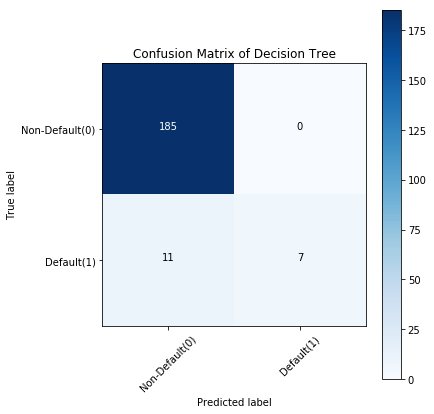

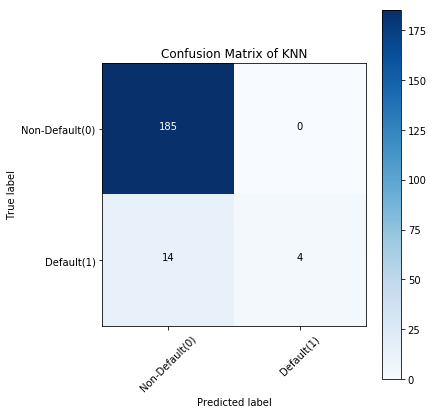

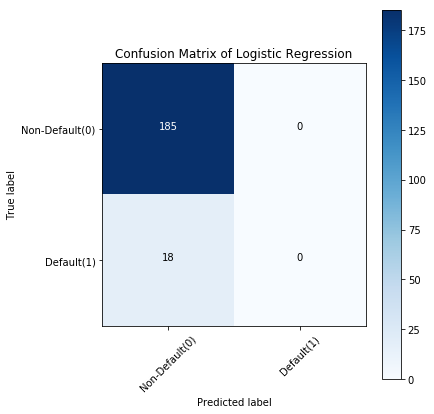

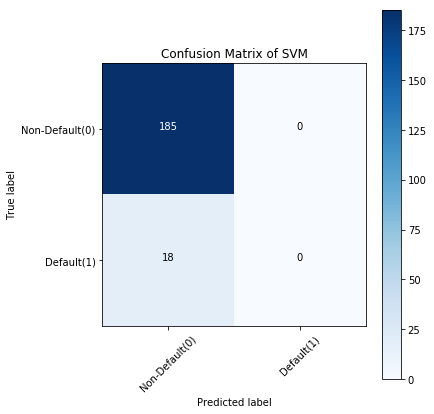

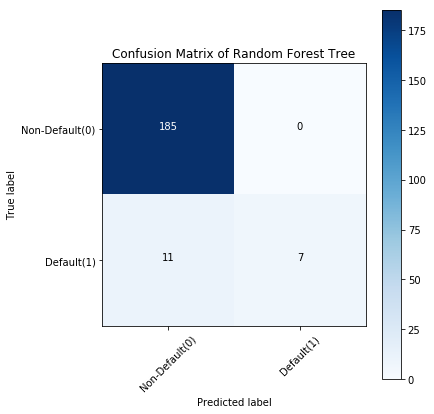

In [273]:
import itertools

def plot_confusion_matrix(cm, classes, title, normalize = False, cmap = plt.cm.Blues):
    title = 'Confusion Matrix of {}'.format(title)
    if normalize:
        cm = cm.astype(float) / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment = 'center',
                 color = 'white' if cm[i, j] > thresh else 'black')

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

tree_matrix = confusion_matrix(y_test, tree_yhat, labels = [0, 1]) # Decision Tree
knn_matrix = confusion_matrix(y_test, knn_yhat, labels = [0, 1]) # K-Nearest Neighbors
lr_matrix = confusion_matrix(y_test, lr_yhat, labels = [0, 1]) # Logistic Regression
svm_matrix = confusion_matrix(y_test, svm_yhat, labels = [0, 1]) # Support Vector Machine
rf_matrix = confusion_matrix(y_test, rf_yhat, labels = [0, 1]) # Random Forest Tree
#xgb_matrix = confusion_matrix(y_test, xgb_yhat, labels = [0, 1]) # XGBoost

# Plot the confusion matrix

plt.rcParams['figure.figsize'] = (6, 6)

# 1. Decision tree

tree_cm_plot = plot_confusion_matrix(tree_matrix, 
                                classes = ['Non-Default(0)','Default(1)'], 
                                normalize = False, title = 'Decision Tree')
plt.savefig('tree_cm_plot.png')
plt.show()

# 2. K-Nearest Neighbors

knn_cm_plot = plot_confusion_matrix(knn_matrix, 
                                classes = ['Non-Default(0)','Default(1)'], 
                                normalize = False, title = 'KNN')
plt.savefig('knn_cm_plot.png')
plt.show()

# 3. Logistic regression

lr_cm_plot = plot_confusion_matrix(lr_matrix, 
                                classes = ['Non-Default(0)','Default(1)'], 
                                normalize = False, title = 'Logistic Regression')
plt.savefig('lr_cm_plot.png')
plt.show()

# 4. Support Vector Machine

svm_cm_plot = plot_confusion_matrix(svm_matrix, 
                                classes = ['Non-Default(0)','Default(1)'], 
                                normalize = False, title = 'SVM')
plt.savefig('svm_cm_plot.png')
plt.show()

# 5. Random forest tree

rf_cm_plot = plot_confusion_matrix(rf_matrix, 
                                classes = ['Non-Default(0)','Default(1)'], 
                                normalize = False, title = 'Random Forest Tree')
plt.savefig('rf_cm_plot.png')
plt.show()

Out of the 3 models above -- Decision tree, KNN and Random Forest tree we get the best results using the Random Forest model followed by KNN and then Decision Tree.

Summary: The data above has a class imbalance problem. there are less number of fraudulent transactions. Given more time some measures can be taken to solve that to get better evaluation results for F1 score. Also there are some features which has low correlation with the target variable so they have been removed from the analysis.

Decision trees often perform well on imbalanced datasets. The splitting rules that look at the class variable used in the creation of the trees, can force both classes to be addressed.


## Q3: Devices and applications <a id="C"></a>
### Is the distribution of device_type dependent on the application being accessed, given the identity of the user performing the action? 

In [209]:
grp_by_device_type_application= df.groupby(['user', 'application', 'device_type'],
                                                          as_index=False)['user', 'application', 'device_type'].size()

In [210]:
grp_by_device_type_application

user    application    device_type
user_1  application_1  android        399
                       iphone           6
                       yubikey          4
        application_2  android        127
                       iphone           2
                       yubikey          6
user_2  application_1  android          7
                       iphone          44
                       yubikey         55
        application_2  android          4
                       iphone          17
                       yubikey         28
user_3  application_1  android          4
                       yubikey          8
        application_2  android          3
                       iphone           2
user_4  application_1  android          6
                       iphone           5
        application_2  android        100
                       iphone          89
                       yubikey          1
dtype: int64

As we can see from the above data device type android and yubikey are more in in count with application 1 as compared to application 2 and device type iphone is more in count with application 2. This doesnot mean that any particular device is dependent on any application. The data is distributed.